In [1]:
import sympy as sym
import numpy as np
#import pylab as pl
from IPython.display import display, Math, Latex
sym.init_printing(use_unicode=True)
import sympy.utilities.autowrap as symauto

epss,Dels,nus,ta,tb,pa,pb,kappa,kappb,kas,kbs =\
sym.symbols('epsilon Delta nus ta tb pa pb kappaa kappab kas kbs',real=True)
kapp1a,kapp1b,Las,Lbs = \
sym.symbols('kappa1a kappa1b Las Lbs',real=True)

#Functions for evaluation
Ema = sym.exp(sym.I*(-nus*ta+pa))
Emb = sym.exp(sym.I*(-nus*tb+pb))
Epa = sym.exp(sym.I*(nus*ta+pa))
Epb = sym.exp(sym.I*(nus*tb+pb))
dma = kappa-sym.I*(nus-Dels) + kas*Epa         #d_{-,a}(\nu)
dmb = kappb-sym.I*(nus+Dels) + kbs*Epb         #d_{-,b}(\nu)
dpa = kappa-sym.I*(nus+Dels) + kas*sym.conjugate(Ema)   #d_{+,a}(\nu)
dpb = kappb-sym.I*(nus-Dels) + kbs*sym.conjugate(Emb)   #d_{+,b}(\nu)
Lab = sym.Abs(epss)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
Lba = sym.Abs(epss)**2 - dpb*dma          #\Lambda_{ba}(\nu)

#Expectation value of the outgoing photon number
nom_ba = (kappa+kas*sym.cos(pa-nus*ta)-kapp1a*Las)*(kappb+kbs*sym.cos(pb+nus*tb))
nom_ab = (kappb+kbs*sym.cos(pb+nus*tb)-kapp1b*Lbs)*(kappa+kas*sym.cos(pa-nus*ta))
I_pexp  = 4*epss**2*(nom_ba/(Lab*sym.conjugate(Lab))+nom_ab/(Lab*sym.conjugate(Lab)))
I_mexp  = 4*epss**2*(nom_ba/(Lab*sym.conjugate(Lab))-nom_ab/(Lab*sym.conjugate(Lab)))
#display(sym.simplify(sym.expand(I_mexp,complex=True)))
diffp   = sym.Rational(1,2)*(sym.diff(I_pexp,pa)-sym.diff(I_pexp,pb))
diffm   = sym.Rational(1,2)*(sym.diff(I_mexp,pa)-sym.diff(I_mexp,pb))
#display(sym.re(diffm))
#display(diffp)
derivp = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), diffp, modules="numpy")
#derivm = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), diffm, modules="numpy")
#num    = sym.lambdify((nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,ta,tb,phia,phib,La,Lb), I_pexp, modules="numpy")

In [3]:
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import scipy.integrate as integ
from IPython.core.debugger import Tracer
#Tracer()() #this one triggers the debugger

def sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phia,phib,La,Lb):
# Function to determine the phase sensitivity of the setup
    import time
    start  = time.clock()

    ## Parameters from inputs ##
    kapa  = kapa*2*np.pi
    kapb  = kapb*2*np.pi
    La    = La/100.
    Lb    = Lb/100.
    phia  = phia*np.pi
    phib  = phib*np.pi
    taua  = kta/kapa
    taub  = ktb/kapa
    Del   = delta*kapa
    eps   = x*kapa
    kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
    kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
    kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
    kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)

    ka = 2*np.sqrt(ra*(1-ra)*(1-La))*kapa    #k_a (feedback strength in mode a)
    kb = 2*np.sqrt(rb*(1-rb)*(1-Lb))*kapb    #k_b (feedback strength in mode b)
    
    ### EXPRESSIONS ###
    def Ei(nu,t,phi):
        return np.exp(1j*(nu*t+phi))
    def d(nu,t,phi,kap,Del,k): #dpa if Del&phi, dma if -Del&-phi, dmb if Del&-phi, dpb if -Del&phi
        return kap - 1j*(nu+Del) + k*Ei(nu,t,-phi)
    def Lf(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km):#Lab if Del&p is a
        return abs(eps)**2 - d(nu,tp,phip,kapp,Del,kp)*d(nu,tm,-phim,kapm,Del,km)
    def albe(nu,t,phi,kap1,kap2,L): #alpha if quantities for a 1 is order is kept
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-L))*Ei(nu,t,phi)

    def D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L): #Da if p is for b
        return np.sqrt(1-L)*Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km)*Ei(nu,tm,phim) +\
        d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap1,kap2,L)*albe(nu,tm,phim,kap2,kap1,L)

    def E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L): # Da if p is for b
        return np.sqrt(L)*(np.sqrt(2*kap2)*d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap2,kap1,L) +\
        Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km))

    def K(nu,t,phi,kap,k,kap1,L):
        return kap + k*np.cos(phi+nu*t) - kap1*L
    def R(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L): #for Ra p means b
        return np.conj(albe(nu,tm,phim,kap1,kap2,L))*D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L) +\
    np.sqrt(2*kap2*L)*E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L)
    
    def U1(nu,tL,phiL,kapL,kL,kap1L,L,t,phi,kap,k): #in case of ab L is for a
        return 4*K(-nu,tL,phiL,kapL,kL,kap1L,L)*K(nu,t,phi,kap,k,0,0) 
    def U2(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L): # in case of ab p is for b
        return np.abs(D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L))**2 + \
    np.abs(E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L))**2
    def U3(nu,Del,tp,phip,kapp,kp,kap1p,kap2p,Lp,tm,phim,kapm,km,kap1m,kap2m,Lm): # in case of ab p is for b
        return np.conj(albe(-nu,tm,phim,kap1m,kap2m,Lm))*\
    np.conj(R(nu,-Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp))
    def U4(nu,Del,tp,phip,kapp,kp,kap1p,kap2p,Lp,tm,phim,kapm,km,kap1m,kap2m,Lm): # in case of ab p is for b
        return albe(nu,tp,phip,kap2p,kap1p,Lp)*\
    R(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1m,kap2m,Lm)

    #Expectation value of the outgoing photon number
    def I_exp(nu):
        return np.real(eps**2*\
    (U1(nu,taua,phia,kapa,ka,kap1a,La,taub,phib,kapb,kb)/(np.abs(Lf(nu,Del,taua,phia,kapa,ka,taub,phib,kapb,kb))**2) + 
     U1(-nu,taub,phib,kapb,kb,kap1b,Lb,taua,phia,kapa,ka)/(np.abs(Lf(-nu,-Del,taub,phib,kapb,kb,taua,phia,kapa,ka))**2)))
    def I_S(nu):
        return np.real(eps**2*\
    (U1(nu,taua,phia,kapa,ka,kap1a,La,taub,phib,kapb,kb)/(np.abs(Lf(nu,Del,taua,phia,kapa,ka,taub,phib,kapb,kb))**2) - 
     U1(-nu,taub,phib,kapb,kb,kap1b,Lb,taua,phia,kapa,ka)/(np.abs(Lf(-nu,-Del,taub,phib,kapb,kb,taua,phia,kapa,ka))**2)))

#    plt.plot(np.linspace(-25,25,10000),np.real(derivm(np.linspace(-25*2*np.pi,25*2*np.pi,10000),\
#                                                       eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb)))
    plt.plot(np.linspace(-25,25,10000),np.real(I_S(np.linspace(-25,25,10000))))
    # There is 10e-13 worth of imaginary part at the singularities
    plt.show()
    
    def T11(nu):
        return np.real(eps**2*U1(nu,taua,phia,kapa,ka,kap1a,La,taub,phib,kapb,kb)/\
    (np.abs(Lf(nu,Del,taua,phia,kapa,ka,taub,phib,kapb,kb))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def T12(nu):
        return np.real(eps**2*U2(nu,Del,taub,phib,kapb,kb,taua,phia,kapa,ka,kap1a,kap2a,La)/\
    (np.abs(Lf(nu,-Del,taub,phib,kapb,kb,taua,phia,kapa,ka))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def T21(nu):
        return np.real(eps**2*U3(nu,Del,taub,phib,kapb,kb,kap1b,kap2b,Lb,taua,phia,kapa,ka,kap1a,kap2a,La)/\
    (np.abs(Lf(nu,Del,taua,phia,kapa,ka,taub,phib,kapb,kb))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def T22(nu):
        return np.real(eps**2*U4(nu,Del,taub,phib,kapb,kb,kap1b,kap2b,Lb,taua,phia,kapa,ka,kap1a,kap2a,La)/\
    (np.abs(Lf(nu,-Del,taub,phib,kapb,kb,taua,phia,kapa,ka))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def T31(nu):
        return np.real(eps**2*U1(-nu,taub,phib,kapb,kb,kap1b,Lb,taua,phia,kapa,ka)/\
    (np.abs(Lf(nu,Del,taua,phia,kapa,ka,taub,phib,kapb,kb))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def T32(nu):
        return np.real(eps**2*U2(-nu,-Del,taua,phia,kapa,ka,taub,phib,kapb,kb,kap1b,kap2b,Lb)/\
    (np.abs(Lf(nu,Del,taub,phib,kapb,kb,taua,phia,kapa,ka))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def T41(nu):
        return np.real(eps**2*U3(-nu,-Del,taua,phia,kapa,ka,kap1a,kap2a,La,taub,phib,kapb,kb,kap1b,kap2b,Lb)/\
    (np.abs(Lf(nu,-Del,taua,phia,kapa,ka,taub,phib,kapb,kb))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))
    def T42(nu):
        return np.real(eps**2*U4(-nu,-Del,taua,phia,kapa,ka,kap1a,kap2a,La,taub,phib,kapb,kb,kap1b,kap2b,Lb)/\
    (np.abs(Lf(nu,Del,taub,phib,kapb,kb,taua,phia,kapa,ka))**2)/\
    derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb))

    T11_int,T11_err = integ.quad(T11,-np.inf,np.inf)
    T12_int,T12_err = integ.quad(T12,-np.inf,np.inf)
    T21_int,T21_err = integ.quad(T21,-np.inf,np.inf)
    T22_int,T22_err = integ.quad(T22,-np.inf,np.inf)
    T31_int,T31_err = integ.quad(T31,-np.inf,np.inf)
    T32_int,T32_err = integ.quad(T32,-np.inf,np.inf)
    T41_int,T41_err = integ.quad(T41,-np.inf,np.inf)
    T42_int,T42_err = integ.quad(T42,-np.inf,np.inf)

    T1 = T11_int*T12_int
    T2 = T21_int*T22_int
    T3 = T31_int*T32_int
    T4 = T41_int*T42_int

    sens = T1+T2+T3+T4
    sens_err = np.sqrt((T11_err*T12_int)**2+(T11_int*T12_err)**2+(T22_int*T21_err)**2+(T21_int*T22_err)**2+\
    (T32_int*T31_err)**2+(T31_int*T32_err)**2+(T42_int*T41_err)**2+(T41_int*T42_err)**2)
    
    N_res,N_err     = integ.quad(I_exp,-np.inf,np.inf)
    print('The phase sensitivity is', sens,' +/- ',sens_err)
#    print('The uncertainty of output is %.4f +/-' % (uncert_res),uncert_err)
    print('The output particle number is ',N_res,' +/- ',N_err)
        
    end = time.clock()
    time = end-start
    mins = int(time/60.)
    secs = time-mins*60
#    print('The elapsed time: %d mins and %d secs' % (mins,secs))
#    return sens
    #sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phia,phib,La,Lb):    
sens(0.25,0,10,10,0.5,0.5,3.65697017049,3.65697017049,0.1,.0,30,30)
#sens0 = sens(0.1,0,10,10,0.5,0.5,1.8833,1.8833,0,0,0,0)
#senseps = np.zeros(100)
#sensDel = np.zeros(100)
#sensPhi = np.zeros(10)
#for i in range(0,10):
#    sensPhi[i] = sens(0.6,0,10,10,0.5,0.5,1.8833,1.8833,i/100.,-i/100.,0,0)
#    senseps[i] = sens((i+1)/100.,0,10,10,0.5,0.5,1.8833,1.8833,0,0,0,0)
#    sensDel[i] = sens(0,2*(i+1)/100.,10,10,0.5,0.5,1.8833,1.8833,0,0,0,0)
#plt.plot(np.linspace(0,1,10),sensPhi)
#plt.show()
#sens0

/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/nnem614/Documents/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


The phase sensitivity is 5.597332651299779e+32  +/-  1.56094749947e+33
The output particle number is  67.31475955862362  +/-  0.0006447987752049081


In [107]:
np.zeros(4)

array([ 0.,  0.,  0.,  0.])

In [1]:
import sympy as sym
import numpy as np
#import pylab as pl
from IPython.display import display, Math, Latex
sym.init_printing(use_unicode=True)
import sympy.utilities.autowrap as symauto

epss,Dels,nus,ta,tb,pa,pb,kappa,kappb,kas,kbs =\
sym.symbols('epsilon Delta nus ta tb pa pb kappaa kappab kas kbs',real=True)
kapp1a,kapp1b,Las,Lbs = \
sym.symbols('kappa1a kappa1b Las Lbs',real=True)

#Functions for evaluation
Ema = sym.exp(sym.I*(-nus*ta+pa))
Emb = sym.exp(sym.I*(-nus*tb+pb))
Epa = sym.exp(sym.I*(nus*ta+pa))
Epb = sym.exp(sym.I*(nus*tb+pb))
dma = kappa-sym.I*(nus-Dels) + kas*Epa         #d_{-,a}(\nu)
dmb = kappb-sym.I*(nus+Dels) + kbs*Epb         #d_{-,b}(\nu)
dpa = kappa-sym.I*(nus+Dels) + kas*sym.conjugate(Ema)   #d_{+,a}(\nu)
dpb = kappb-sym.I*(nus-Dels) + kbs*sym.conjugate(Emb)   #d_{+,b}(\nu)
Lab = sym.Abs(epss)**2 - dpa*dmb          #\Lambda_{ab}(\nu)
Lba = sym.Abs(epss)**2 - dpb*dma          #\Lambda_{ba}(\nu)

#Expectation value of the outgoing photon number
nom_ba = (kappa+kas*sym.cos(pa-nus*ta)-kapp1a*Las)*(kappb+kbs*sym.cos(pb+nus*tb))
nom_ab = (kappb+kbs*sym.cos(pb+nus*tb)-kapp1b*Lbs)*(kappa+kas*sym.cos(pa-nus*ta))
I_pexp  = 4*epss**2*(nom_ba/(Lab*sym.conjugate(Lab))+nom_ab/(Lab*sym.conjugate(Lab)))
I_mexp  = 4*epss**2*(nom_ba/(Lab*sym.conjugate(Lab))-nom_ab/(Lab*sym.conjugate(Lab)))

diffp   = sym.Rational(1,2)*(sym.diff(I_pexp,pa)-sym.diff(I_pexp,pb))
derivp = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), diffp, modules="numpy")
num    = sym.lambdify((nus,epss,Dels,kappa,kappb,kapp1a,kapp1b,kas,kbs,ta,tb,pa,pb,Las,Lbs), I_pexp, modules="numpy")

KeyboardInterrupt: 

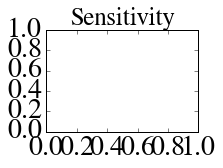

In [9]:
import numpy as np
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integ
from IPython.core.debugger import Tracer
#Tracer()() #this one triggers the debugger

mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=28)
mpl.rc('ytick',labelsize=28)

def sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phia,phib,La,Lb):
# Function to determine the phase sensitivity of the setup
    import time
    start  = time.clock()

    ## Parameters from inputs ##
    kapa  = kapa*2*np.pi
    kapb  = kapb*2*np.pi
    La    = La/100.
    Lb    = Lb/100.
    phia  = phia*np.pi
    phib  = phib*np.pi
    taua  = kta/kapa
    taub  = ktb/kapa
    Del   = delta*kapa
    eps   = x*kapa
    kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
    kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
    kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
    kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)

    ka = 2*np.sqrt(ra*(1-ra)*(1-La))*kapa    #k_a (feedback strength in mode a)
    kb = 2*np.sqrt(rb*(1-rb)*(1-Lb))*kapb    #k_b (feedback strength in mode b)
    
    ### EXPRESSIONS ###
    def Ei(nu,t,phi):
        if isinstance(t,str):
            display(t)
        return np.exp(1j*(nu*t+phi))
    def d(nu,t,phi,kap,Del,k):
        return kap - 1j*(nu+Del) + k*Ei(nu,t,phi)
    def Lf(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km):
        return abs(eps)**2 - d(nu,tp,phip,kapp,Del,kp)*d(nu,tm,phim,kapm,-Del,km)

    def albe(nu,t,phi,kap1,kap2,L):
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-L))*Ei(nu,t,phi)
    def D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L):
        return np.sqrt(1-L)*Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km)*Ei(nu,tm,phim) +\
        d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap1,kap2,L)*albe(nu,tm,phim,kap2,kap1,L)

    def E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L):
        return np.sqrt(L)*np.sqrt(2*kap2)*d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap2,kap1,L) +\
        Lf(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km)

    def K(nu,t,phi,kap,k,kap1,L):
        return kap + k*np.cos(phi+nu*t) - kap1*L
    def R(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L): #for Ra p means b
        return np.conj(albe(nu,tm,phim,kap1,kap2,L))*D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L) +\
    np.sqrt(2*kap2*L)*E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L)
    
    def U(nu,nup,tp,phip,kapp,Del,kp,Lp,kap1p,kap2p,tm,phim,kapm,km,Lm,kap1m,kap2m): #in case of Uab a is p
        return 4*K(-nu,tp,phip,kapp,kp,kap1p,Lp)*K(nu,tm,phim,kapm,km,kap1m,0)*\
    (abs(D(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp))**2+\
     abs(E(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp))**2) +\
    np.conj(albe(-nu,tp,phip,kap2p,kap1p,Lp))*np.conj(R(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1m,kap2m,Lm))*\
    albe(nup,tm,phim,kap2m,kap1m,Lm)*R(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp)
    
    def uncert(nu,nup):
        return np.abs(eps)**2*(U(nu,nup,taua,phia,kapa,Del,ka,La,kap1a,kap2a,taub,phib,kapb,kb,Lb,kap1b,kap2b)+\
                               U(-nu,-nup,taub,phib,kapb,Del,kb,Lb,kap1b,kap2b,taua,phia,kapa,ka,La,kap1a,kap2a))/\
                            (np.abs(Lf(nu,Del,taua,phia,kapa,ka,taub,phib,kapb,kb))**2*\
                            np.abs(Lf(nup,-Del,taub,phib,kapb,kb,taua,phia,kapa,ka))**2)
    def denom(nu,nup):
        return derivp(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb)*\
    derivp(nup,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb) 
    
    def N(nu):
        return num(nu,eps,Del,kapa,kapb,kap1a,kap1b,ka,kb,taua,taub,phia,phib,La,Lb) 
    
    def sens(nu,nup):
        return uncert(nu,nup)/denom(nu,nup)
    
#    sens_res,sens_err     = integ.dblquad(sens, -np.inf, np.inf, \
#                                          lambda nu: np.real(sens(nu,-np.inf)), lambda nu: np.real(sens(nu,np.inf)))
#    uncert_res,uncert_err = integ.dblquad(uncert, -np.inf, np.inf, \
#                                          lambda nu: np.real(uncert(nu,-np.inf)), lambda nu: np.real(uncert(nu,np.inf)))
#    N_res,N_err           = integ.quad(N,-np.inf,np.inf)
   # sens_res = 0.5
   # sens_err = 1.4e-12
#    print('The phase sensitivity is %.4f +/-' % (sens_res),sens_err)
#    print('The uncertainty of output is %.4f +/-' % (uncert_res),uncert_err)
#   print('The output particle number is %.4f +/-' % (N_res),N_err)

    lims = 25.
    ND   = 1001
    nu  = np.linspace(-lims,lims,ND)
    nus = np.linspace(-lims,lims,ND)
    nup = np.linspace(-lims,lims,ND)
    nu,nup = np.meshgrid(nu,nup)
    fsfont = {'fontname':'FreeSerif'}

    colors={'brown':(200/255.,154/255.,125/255.),\
        'green':(0,151/255.,78/255.),\
        'blue':(0,120/255.,180/255.),\
        'yellow':(1., 215/255., 0),\
        'black':(0.,0.,0.)}
    tickfont  = 18.
    labelfont = 21.
    titlefont = 25.
    
    plt.subplot(221)
    plt.title("Sensitivity",**fsfont,fontsize=titlefont)
    plt.contourf(nu,nup,np.real(sens(2*nu*np.pi,2*nup*np.pi)),300)
    plt.xlabel("$\\nu$",**fsfont,fontsize=labelfont)
    plt.ylabel("$\\nu^\prime$",**fsfont,fontsize=labelfont)
    cb1  = plt.colorbar()
    cb1.formatter.set_powerlimits((0, 0))
    cb1.ax.tick_params(labelsize=tickfont-5)
    cb1.update_ticks()
    plt.xticks(fontsize = tickfont,**fsfont)
    plt.yticks(fontsize = tickfont,**fsfont)

    plt.subplot(222)
    plt.title("Uncertainty in $I_{-}(\\nu,\\nu^\\prime)$",**fsfont,fontsize=titlefont)
    plt.contourf(nu,nup,np.real(uncert(2*nu*np.pi,2*nup*np.pi)), 300)
    plt.xlabel("$\\nu$",**fsfont,fontsize=labelfont)
    plt.ylabel("$\\nu^\prime$",**fsfont,fontsize=labelfont)
    cb2  = plt.colorbar()
    cb2.ax.tick_params(labelsize=tickfont-5)
    cb2.formatter.set_powerlimits((0, 0))
    cb2.update_ticks()
#    plt.xlim(-3,3)
#    plt.ylim(-3,3)
    plt.xticks(fontsize = tickfont,**fsfont)
    plt.yticks(fontsize = tickfont,**fsfont)
    
    plt.subplot(223)
    plt.title("Phase gradient of $I_{-}(\\nu,\\nu^\\prime)$",**fsfont,fontsize=titlefont)
    plt.contourf(nu,nup,np.real(denom(2*nu*np.pi,2*nup*np.pi)),300)
    plt.xlabel("$\\nu$",**fsfont,fontsize=labelfont)
    plt.ylabel("$\\nu^\prime$",**fsfont,fontsize=labelfont)
    cb3  = plt.colorbar()
    cb3.ax.tick_params(labelsize=tickfont-5)
    cb3.formatter.set_powerlimits((0, 0))
    cb3.update_ticks()
    plt.xticks(fontsize = tickfont,**fsfont)
   # plt.xlim(-10,10)
   # plt.ylim(-10,10)
    plt.yticks(fontsize = tickfont,**fsfont)

    plt.subplot(224)
    plt.title("Output particle number",**fsfont,fontsize=titlefont)
    plt.plot(nus,np.real(N(2*np.pi*nus)),linewidth=2,color = colors['brown'])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,1))
    plt.grid(True)
    plt.xlabel("$\\nu$",**fsfont,fontsize=labelfont)
    plt.ylabel("$N$",**fsfont,fontsize=labelfont)
    plt.xticks(fontsize = tickfont,**fsfont)
    plt.yticks(fontsize = tickfont,**fsfont)
    plt.show()
    
    sens_mat = np.abs(np.real(sens(2*nu*np.pi,2*nup*np.pi)))
    sens_min = np.min(sens_mat)
    sens_ind = sens_mat.argmin()
    sens_dim = len(sens_mat[:,1])
    sens_i_r = int(sens_ind/sens_dim)
    sens_i_c = sens_ind-sens_dim*sens_i_r
    print('min sensitivity:',sens_min,"\nmin freq:",nu[sens_i_r,sens_i_c],"and",nup[sens_i_r,sens_i_c])
    #print("check:",np.real(sens(2*np.pi*nu[sens_i_r,sens_i_c],2*np.pi*nup[sens_i_r,sens_i_c])))
#sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phia,phib,La,Lb):    
sens(0.25,0.0,10,10,0.5,0.5,3.65697017049,3.65697017049,.0,0,0.,0.0)

In [343]:
np.arccos(-.75)/np.sqrt(1-.75**2)
np.sqrt(1-.75**2)*10

In [330]:
probe = np.matrix([[4,3,2,4],[5,9,3,4],[1,5,6,7],[5,6,7,2]])
print('min of probe:',np.min(probe))
vecind = probe.argmin()
dim    = len(probe[:,1])
n_row = int(vecind/dim)
print("min row index:",n_row)
print("min column index:",vecind-dim*n_row)

min of probe: 1
min row index: 1
min column index: 1


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integ
from IPython.core.debugger import Tracer
from matplotlib.colors import LogNorm
import numdifftools as nd
#Tracer()() #this one triggers the debugger

mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=20)
mpl.rc('ytick',labelsize=20)

def sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phib,La,Lb):
# Function to determine the phase sensitivity of the setup
    import time
    start  = time.clock()

    ## Parameters from inputs ##
    kapa  = kapa*2*np.pi
    kapb  = kapb*2*np.pi
    La    = La/100.
    Lb    = Lb/100.
    phib  = phib*np.pi
    taua  = kta/kapa
    taub  = ktb/kapa
    Del   = delta*kapa
    eps   = x*kapa
    kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
    kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
    kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
    kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)

    ka = 2*np.sqrt(ra*(1-ra)*(1-La))*kapa    #k_a (feedback strength in mode a)
    kb = 2*np.sqrt(rb*(1-rb)*(1-Lb))*kapb    #k_b (feedback strength in mode b)
    
    ### EXPRESSIONS ###
    def Ei(nu,t,phi):
        return np.exp(1j*(nu*t+phi))
    def d(nu,t,phi,kap,Del,k): #dpa if Del&phi, dma if -Del&-phi, dmb if Del&-phi, dpb if -Del&phi
        return kap - 1j*(nu+Del) + k*Ei(nu,t,-phi)
    def Lf(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,eps):#Lab if Del&p is a
        return abs(eps)**2 - d(nu,tp,phip,kapp,Del,kp)*d(nu,tm,-phim,kapm,Del,km)
    def K(nu,t,phi,kap,k,kap1,L):
        return kap + k*np.cos(phi+nu*t) - kap1*L    
    def U1(nu,tL,phiL,kapL,kL,kap1L,L,t,phi,kap,k): #in case of ab L is for a
        return 4*K(-nu,tL,phiL,kapL,kL,kap1L,L)*K(nu,t,phi,kap,k,0,0)
    def albe(nu,t,phi,kap1,kap2,L):
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-L))*Ei(nu,t,phi)
    def D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps):
        return np.sqrt(1-L)*Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km,eps)*Ei(nu,tm,phim) +\
        d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap1,kap2,L)*albe(nu,tm,phim,kap2,kap1,L)
    def E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps):
        return np.sqrt(L)*np.sqrt(2*kap2)*d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap2,kap1,L) +\
        Lf(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,eps)
    def R(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps): #for Ra p means b
        return np.conj(albe(nu,tm,phim,kap1,kap2,L))*D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps) +\
    np.sqrt(2*kap2*L)*E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps)
    
    def U(nu,nup,tp,phip,kapp,Del,kp,Lp,kap1p,kap2p,tm,phim,kapm,km,Lm,kap1m,kap2m,eps): #in case of Uab a is p
        return 4*K(-nu,tp,phip,kapp,kp,kap1p,Lp)*K(nu,tm,phim,kapm,km,kap1m,0)*\
    (abs(D(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp,eps))**2+\
     abs(E(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp,eps))**2) +\
    np.conj(albe(-nu,tp,phip,kap2p,kap1p,Lp))*np.conj(R(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1m,kap2m,Lm,eps))*\
    albe(nup,tm,phim,kap2m,kap1m,Lm)*R(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp,eps)
    
    #Uncertainty of the particle number 
    def uncert(nu,nup,phi,eps):
        return np.abs(eps)**2*(U(nu,nup,taua,phib+phi,kapa,Del,ka,La,kap1a,kap2a,taub,phib,kapb,kb,Lb,kap1b,kap2b,eps)+\
                               U(-nu,-nup,taub,phib,kapb,Del,kb,Lb,kap1b,kap2b,taua,phib+phi,kapa,ka,La,kap1a,kap2a,eps))/\
                            (np.abs(Lf(nu,Del,taua,phib+phi,kapa,ka,taub,phib,kapb,kb,eps))**2*\
                            np.abs(Lf(nup,-Del,taub,phib,kapb,kb,taua,phib+phi,kapa,ka,eps))**2)
    def unc_int(phi,eps):
        res,err = integ.dblquad(uncert,-np.inf,np.inf,lambda nup: -np.inf,lambda nup: np.inf, args=(phi,eps))
    ##IMPORTANT! This double integral only works with python 3.
    
    #Expectation value of the outgoing photon number
    def I_exp(nu,phi,eps):
        return np.real(eps**2*\
    (U1(nu,taua,phib+phi,kapa,ka,kap1a,La,taub,phib,kapb,kb)/(np.abs(Lf(nu,Del,taua,phib+phi,kapa,ka,taub,phib,kapb,kb,eps))**2) + 
     U1(-nu,taub,phib,kapb,kb,kap1b,Lb,taua,phib+phi,kapa,ka)/(np.abs(Lf(-nu,-Del,taub,phib,kapb,kb,taua,phib+phi,kapa,ka,eps))**2)))
    def I_int(phi,eps):
        res,err = integ.quad(I_exp,-np.inf,np.inf,args=(phi,eps))
        #print(res)
        return res
    
    nus  = np.linspace(-20,20,501)
    phis = np.linspace(-1,1,101)
    nu,phi = np.meshgrid(nus,phis)
    
    fsfont = {'fontname':'FreeSerif','fontsize':30}
    
    #plt.figure(1,figsize=(12,8))
    #plt.contourf(nu,phi,I_exp(2*np.pi*nu, np.pi*phi,.75*kapa),400,cmap=plt.cm.jet,norm = LogNorm())
    #plt.colorbar()
    #plt.xlabel("$\\nu$ ($2\pi$ MHz)",**fsfont)
    #plt.ylabel("$\phi (\pi)$",**fsfont)
    
    colors={'brown':(200/255.,154/255.,125/255.),
            'green':(0,151/255.,78/255.),
            'blue':(0,120/255.,180/255.),
            'yellow':(1., 215/255., 0),
            'black':(0.,0.,0.)}
    collab = ['brown','green','blue','yellow','black']
    linew  = [2,2,3,4,5]
    linest = ['-','--','-.',':','-']


    xstr = [None]*4
    fig,axes=plt.subplots(1,1,figsize=(22,8))
    #integral = np.zeros((len(phis)))
    #derivati = np.zeros((len(phis)))
    uncertain = np.zeros((len(phis)))
    for j in range(4):
        eps = (x-j*.05)*kapa
        xstr[j] = str(x-j*.05)
        for i in range(len(phis)):
            uncertain[i] = unc_int(phis[i]*np.pi,eps)
    #        def der(phi):
    #            return I_int(phi,eps)
    #        deri = nd.Derivative(der)
    #        derivati[i] = deri(phis[i]*np.pi)
    #        integral[i] = I_int(phis[i]*np.pi,eps) 
        axes.plot(phis,uncertain,linewidth=linew[j],color = collab[j],ls=linest[j])
    #    axes[0].plot(phis,integral,linewidth=linew[j],color = collab[j],ls=linest[j])
    #    axes[1].plot(phis,derivati,linewidth=linew[j],color = collab[j],ls=linest[j])
    #for im in range(2):
    #    axes[im].set_xlabel("$\phi (\pi)$",**fsfont)
    #    axes[im].legend(xstr,fontsize = 20)
    #    axes[im].grid(True)
    axes.set_xlabel("$\phi (\pi)$",**fsfont)
    axes.legend(xstr,fontsize = 20)
    axes.grid(True)
    #axes[0].set_yscale('log')
    #axes[0].ylabel("Detected photon number",**fsfont)
    axes.ylabel("$\Delta I (\phi)$",**fsfont)
    #axes[1].ylabel("Derivative",**fsfont)
    
    plt.show()
    
#sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phib,La,Lb)
sens(.75,0,10,10,0.5,0.5,1.8833,1.8833,0,0,0)

/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/integrate/quadpack.py:383: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The int